In [1]:
import sys
import importlib.util

def check_dependencies():
    """Check if all required packages are installed"""
    required_packages = {
        'lightgbm': 'For loading and using the trained model',
        'pandas': 'For data manipulation',
        'numpy': 'For numerical operations',
        'matplotlib': 'For creating static visualizations',
        'seaborn': 'For enhanced visualizations',
        'folium': 'For creating interactive maps',
        'branca': 'For map coloring utilities'
    }
    
    missing_packages = []
    
    for package, purpose in required_packages.items():
        if importlib.util.find_spec(package) is None:
            missing_packages.append(f"- {package}: {purpose}")
    
    if missing_packages:
        print("Missing required packages:")
        print("\n".join(missing_packages))
        print("\nPlease install missing packages using:")
        print("pip install " + " ".join(package.split(':')[0].strip('- ') for package in missing_packages))
        sys.exit(1)
    else:
        print("All required packages are installed!")

# Add imports after dependency check
check_dependencies()

All required packages are installed!


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import branca.colormap as cm


In [3]:
from datetime import timedelta
import random

In [4]:
def day_of_week (df):
    if ('day_of_week' in df.columns):
        print("day_of_week exist, skipping")
    else:    
        # Add day_of_week based on date
        df['day_of_week'] = pd.to_datetime(
            df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + 
            df['day'].astype(str) + ' ' + 
            df['hour'].astype(str) + ':00:00'
        ).dt.dayofweek

def load_and_prepare_data():
    """
    Load and prepare the original training data
    """
    # Load the data
    df = pd.read_csv(r'C:\Users\ignas\OneDrive\Documents\Postgrau_UB\17.Capstone_project\data\Train_prepared_v2.csv')
    day_of_week(df)
    # Convert datetime
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Convert boolean and categorical columns
    bool_columns = ['lag_1h_is_interpolated', 'lag_2h_is_interpolated', 
                   'lag_3h_is_interpolated', 'lag_4h_is_interpolated']
    for col in bool_columns:
        df[col] = df[col].map({'True': True, 'False': False})
    
    cat_columns = ['FCB_Location', 'FCB_Score', 
                  't_lag_1h_FCB_Location', 't_lag_1h_FCB_Score',
                  't_lag_2h_FCB_Location', 't_lag_2h_FCB_Score',
                  't_lag_3h_FCB_Location', 't_lag_3h_FCB_Score',
                  't_lag_4h_FCB_Location', 't_lag_4h_FCB_Score',
                  't_lead_1h_FCB_Location', 't_lead_1h_FCB_Score',
                  't_lead_2h_FCB_Location', 't_lead_2h_FCB_Score',
                  't_lead_3h_FCB_Location', 't_lead_3h_FCB_Score',
                  't_lead_4h_FCB_Location', 't_lead_4h_FCB_Score']
    
    for col in cat_columns:
        df[col] = df[col].astype('category')
    
    return df

def get_feature_columns():
    """
    Return the feature columns used in the model
    """
    return ['station_id', 'month', 'day', 'hour',
           'lag_4h_percentage_docks_available',
           'lag_3h_percentage_docks_available',
           'lag_2h_percentage_docks_available',
           'lag_1h_percentage_docks_available', 'capacity', 'lat', 'lon',
           'altitude', 'post_code', 'year', 'day_of_week',
           'lag_1h_is_interpolated', 'lag_2h_is_interpolated',
           'lag_3h_is_interpolated', 'lag_4h_is_interpolated', 'FCB_Location',
           'FCB_Score', 'wea_prep', 'wea_sun', 'wea_temp', 'wea_wind_sp',
           'holiday', 'd_lag_1d_holiday', 'd_lead_1d_holiday',
           't_lag_1h_FCB_Location', 't_lag_1h_FCB_Score', 't_lag_1h_wea_prep',
           't_lag_1h_wea_sun', 't_lag_1h_wea_temp', 't_lag_1h_wea_wind_sp',
           't_lag_2h_FCB_Location', 't_lag_2h_FCB_Score', 't_lag_2h_wea_prep',
           't_lag_2h_wea_sun', 't_lag_2h_wea_temp', 't_lag_2h_wea_wind_sp',
           't_lag_3h_FCB_Location', 't_lag_3h_FCB_Score', 't_lag_3h_wea_prep',
           't_lag_3h_wea_sun', 't_lag_3h_wea_temp', 't_lag_3h_wea_wind_sp',
           't_lag_4h_FCB_Location', 't_lag_4h_FCB_Score', 't_lag_4h_wea_prep',
           't_lag_4h_wea_sun', 't_lag_4h_wea_temp', 't_lag_4h_wea_wind_sp',
           't_lead_1h_FCB_Location', 't_lead_1h_FCB_Score', 't_lead_1h_wea_prep',
           't_lead_1h_wea_sun', 't_lead_1h_wea_temp', 't_lead_1h_wea_wind_sp',
           't_lead_2h_FCB_Location', 't_lead_2h_FCB_Score', 't_lead_2h_wea_prep',
           't_lead_2h_wea_sun', 't_lead_2h_wea_temp', 't_lead_2h_wea_wind_sp',
           't_lead_3h_FCB_Location', 't_lead_3h_FCB_Score', 't_lead_3h_wea_prep',
           't_lead_3h_wea_sun', 't_lead_3h_wea_temp', 't_lead_3h_wea_wind_sp',
           't_lead_4h_FCB_Location', 't_lead_4h_FCB_Score', 't_lead_4h_wea_prep',
           't_lead_4h_wea_sun', 't_lead_4h_wea_temp', 't_lead_4h_wea_wind_sp']

def get_categorical_features():
    """Return the list of categorical feature names"""
    return ['FCB_Location', 'FCB_Score',
            't_lag_1h_FCB_Location', 't_lag_1h_FCB_Score',
            't_lag_2h_FCB_Location', 't_lag_2h_FCB_Score',
            't_lag_3h_FCB_Location', 't_lag_3h_FCB_Score',
            't_lag_4h_FCB_Location', 't_lag_4h_FCB_Score',
            't_lead_1h_FCB_Location', 't_lead_1h_FCB_Score',
            't_lead_2h_FCB_Location', 't_lead_2h_FCB_Score',
            't_lead_3h_FCB_Location', 't_lead_3h_FCB_Score',
            't_lead_4h_FCB_Location', 't_lead_4h_FCB_Score']

def prepare_data_for_prediction(df_row, feature_columns):
    """Prepare a single row of data for prediction"""
    data = pd.DataFrame([df_row[feature_columns]])
    cat_features = get_categorical_features()
    
    # Ensure categorical features are properly encoded
    for col in cat_features:
        if col in data.columns:
            data[col] = data[col].astype('category')
    
    return data

In [5]:

def create_impact_map(results_df, title, filename, which_result,lim_inf=5, lim_sup=95, colormap=1):
    """Create an interactive map showing station impacts"""
    # Create the map centered on Barcelona
    m = folium.Map(location=[41.403278, 2.174055], zoom_start=13, rotate=30) 
    
    # Find color limits
    p10 = np.percentile(results_df[which_result], 10)
    p90 = np.percentile(results_df[which_result], 90)

    if p10<0:
        lim_inf = lim_inf
        lim_sup = lim_sup

    else:
        lim_inf = 5
        lim_sup = 95

    if colormap ==1:
        # Create a color scale
        colormap = cm.LinearColormap(
            colors=['purple', 'blue', 'green', 'yellow'],
            vmin=lim_inf,
            vmax=lim_sup
        )
    elif colormap ==2:
        # Create a color scale
        colormap = cm.LinearColormap(
            colors=['red', 'lightgray', 'blue'],
            vmin=lim_inf,
            vmax=lim_sup
        )
    
    # Add the colormap to the map
    colormap.add_to(m)
    colormap.caption = title
    
    # Inject custom CSS to enlarge the legend
    legend_css = """
    <style>
        .legend {
            font-size: 16px !important;
            padding: 10px;
            line-height: 20px;
        }
    </style>
    """
    m.get_root().html.add_child(folium.Element(legend_css))

    # Add markers for each station
    for _, row in results_df.iterrows():
        color = colormap(row[which_result] * 100)
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=8,
            popup=f"Station {row['station_id']}<br>"
                  f"Result: {row[which_result]*100:.1f}%<br>",
            color=color,
            fill=True,
            fill_color=color
        ).add_to(m)
    
    # Save the map
    m.save(f'analysis_results/{filename}.html')

In [6]:
def analyze_game_impact_all_stations(df, model, match_column = 't_lead_1h_FCB_Location'):
    """
    Analyze the impact of games across all stations
    """
    print("\nAnalyzing Game Impact Across All Stations")
    print("-" * 50)
    
    # Find home games
    print("Finding weekend home games...")
    game_times = df[
        (df[match_column] == 'C') & 
        (df['day_of_week'].isin([5, 6])) &  # Weekend games
        (df['hour'].between(18, 22))  # Evening games
    ]['datetime'].unique()
    
    print(f"Found {len(game_times)} games matching criteria")
    
    all_results = []
    analyzed_games = 0
    
    selected_game_times = list(game_times[:3]) + list(game_times[-3:])

    for i, game_time in enumerate(selected_game_times, start=1):
        print(f"\nAnalyzing game ({game_time})")
        
        # Get game data
        game_data = df[
            (df['datetime'] == game_time)
        ].iloc[0]
        game_hour = game_data['hour']

        print(f"Game details:")
        print(f"- Time: {game_data['hour']}:00")
        print(f"- Temperature: {game_data['wea_temp']}°C")
        print(f"- Weather: {'Rainy' if game_data['wea_prep'] > 0 else 'Clear'}")
        
        game_date = pd.Timestamp(game_time).date()

        # Get all stations data for the game day
        print("\nGetting station data for game day...")
        game_day_stations = df[
            (df['datetime'] == game_time)
        ]
        print(f"Found {len(game_day_stations)} stations with data")
        
        # Find similar non-game day
        print("\nSearching for similar non-game day...")
        similar_date = None
        for days in range(7 , 15*7, 7):
            candidate_date = pd.Timestamp(game_time) + timedelta(days=days)
            candidate_data = df[
                (df['datetime'].dt.date == pd.Timestamp(candidate_date).date()) &
                (df['hour'] == game_hour) &
                (df[match_column] == 'NoMatch')
            ]
            
            if len(candidate_data) > 0:
                avg_temp = candidate_data['wea_temp'].iloc[0]
                if abs(avg_temp - game_data['wea_temp']) < 5:
                    similar_date = candidate_date
                    print(f"Found similar date: {similar_date}")
                    print(f"- Temperature difference: {abs(avg_temp - game_data['wea_temp']):.1f}°C")
                    break
        
        if similar_date is None:
            print("Could not find suitable comparison date, skipping game")
            continue
            
        # Get non-game day data
        print("\nGetting comparison day data...")
        non_game_day_stations = df[
            (df['datetime'].dt.date == similar_date.date()) &
            (df['hour'] == game_hour)
        ]
        print(f"Found {len(non_game_day_stations)} stations with comparison data")
        
        # Analyze each station
        print("\nAnalyzing individual stations...")
        feature_columns = get_feature_columns()
        game_results = []
        
        total_stations = len(game_day_stations)
        for idx, (_, game_row) in enumerate(game_day_stations.iterrows(), 1):
            if idx % 50 == 0:  # Progress update every 50 stations
                print(f"Processing station {idx}/{total_stations}")
                
            non_game_row = non_game_day_stations[
                non_game_day_stations['station_id'] == game_row['station_id']
            ].iloc[0]
            
            # Predict with different game scenarios
            game_row_no_match = game_row.copy()
            non_game_row_match = non_game_row.copy()
            
            # Modify game status columns
            # Select all columns containing "FCB_Location"
            game_columns = [col for col in df.columns if "FCB" in col]

            # Change game columns to 'NoMatch'
            for col in game_columns:
                game_row_no_match[col] = 'NoMatch'
                non_game_row_match[col] = game_row[col]

            # Predictions with proper data preparation
            pred_with_game = model.predict(prepare_data_for_prediction(game_row, feature_columns))[0]
            pred_without_game = model.predict(prepare_data_for_prediction(game_row_no_match, feature_columns))[0]
            
            non_game_pred_without_game = model.predict(prepare_data_for_prediction(non_game_row, feature_columns))[0]
            non_game_pred_with_game = model.predict(prepare_data_for_prediction(non_game_row_match, feature_columns))[0]
            
            game_results.append({
                'game_time': game_time,
                'station_id': game_row['station_id'],
                'lat': game_row['lat'],
                'lon': game_row['lon'],

                'actual_game_day': game_row['percentage_docks_available'],
                'predicted_with_game': pred_with_game,
                'predicted_without_game': pred_without_game,
                'pred_diff_game_day': pred_with_game - pred_without_game,

                'actual_non_game_day': non_game_row['percentage_docks_available'],
                'non_game_predicted_without_game': non_game_pred_without_game,
                'non_game_predicted_with_game': non_game_pred_with_game,
                'pred_diff_non_game_day':  non_game_pred_with_game - non_game_pred_without_game,


                'actual_difference_hourly_change': (game_row['percentage_docks_available']-game_row['lag_1h_percentage_docks_available']) - (non_game_row['percentage_docks_available'] - non_game_row['lag_1h_percentage_docks_available']),
            })
        
        all_results.extend(game_results)
        analyzed_games += 1
        
        # Create visualization for this game
        print("\nCreating visualizations...")
        game_results_df = pd.DataFrame(game_results)
        results_to_map = ['actual_game_day','predicted_with_game', 'predicted_without_game','actual_non_game_day','non_game_predicted_without_game', 'non_game_predicted_with_game']
        for result in results_to_map:
            create_impact_map(game_results_df, f"Game Impact {game_date}_{game_hour}_{match_column}_{result}", f"game_impact_{game_date}_{game_hour}_{match_column}_{result}",result)
        
        results_to_map2 = ['pred_diff_game_day','pred_diff_non_game_day']
        for result in results_to_map2:
            create_impact_map(game_results_df, f"Game Impact {game_date}_{game_hour}_{match_column}_{result}", f"game_impact_{game_date}_{game_hour}_{match_column}_{result}",result, lim_inf=-5, lim_sup=5, colormap=2 )
        

        # Print summary statistics
        print(f"\nResults summary for game on {game_date}:")
        print(f"Average predicted impact: {game_results_df['pred_diff_game_day'].mean()*100:.1f}%")
        print(f"Max Availability INCREASE predicted impact: {game_results_df['pred_diff_game_day'].max()*100:.1f}%")
        print(f"Max Availability DECREASE predicted impact: {game_results_df['pred_diff_game_day'].min()*100:.1f}%")
        print(f"Number of stations analyzed: {len(game_results)}")
    
    print(f"\nAnalysis complete! Analyzed {analyzed_games} games")
    
    # Analyze patterns across all games
    print("\nCreating summary visualizations...")
    all_results_df = pd.DataFrame(all_results)
    
    plt.figure(figsize=(12, 6))
    plt.hist(all_results_df[results_to_map2[0]] * 100, bins=30)
    plt.title('Distribution of Predicted Game Impact Across All Stations')
    plt.xlabel('Predicted Change in Availability (%)')
    plt.ylabel('Number of Stations')
    plt.savefig(f'analysis_results/game_impact_distribution_diff_game_day_{match_column}.png')
    plt.close()

    plt.figure(figsize=(12, 6))
    plt.hist(all_results_df[results_to_map2[1]] * 100, bins=30)
    plt.title('Distribution of Predicted Game Impact Across All Stations')
    plt.xlabel('Predicted Change in Availability (%)')
    plt.ylabel('Number of Stations')
    plt.savefig(f'analysis_results/game_impact_distribution_diff_non_game_day_{match_column}.png')
    plt.close()
    
    print("Analysis completed successfully!")
    return all_results_df

In [7]:
def analyze_rain_impact(df, model):
    """
    This function analyzes the impact of rain across all stations by comparing bike dock availability 
    during rainy episodes to similar non-rainy conditions. It utilizes a predictive model to assess 
    the changes in dock availability and visualize the results.
    """
    print("\nStarting Rain Impact Analysis Across All Stations...")
    print("-" * 80)
    
    # Identify significant rain events where rain persists for multiple hours during the day
    print("Identifying significant rain events with continued precipitation...")
    rain_times = df[
        (df['wea_prep'] > 1) &  # Considered significant rainfall threshold
        (df['t_lead_1h_wea_prep'] > 1) &  # Predicted rain in the next hour
        (df['t_lead_2h_wea_prep'] > 0.2) &  # Predicted rain in two hours
        (df['day_of_week'].between(0, 4)) & 
        (df['holiday']==0) & 
        (df['hour'].between(9, 19))  # Focusing on daytime hours for analysis
    ]['datetime'].unique()
    
    all_results = []
    
    # Analyze the impact of the first three significant rain episodes
    print("Selecting three rain episodes for in-depth analysis...")
    for rain_time in random.sample(list(rain_times), min(3, len(rain_times))):
        print(f"\nAnalyzing rain episode on {rain_time}...")
        rain_date = pd.Timestamp(rain_time).date()
        rain_data = df[df['datetime'] == rain_time].iloc[0]
        rain_hour = rain_data['hour']
        print(f"Time of rain: {rain_hour}:00")
        print(f"Recorded rain intensity: {rain_data['wea_prep']:.2f}")
        print(f"Temperature during rain: {rain_data['wea_temp']}°C")
        
        # Extract station data for the rainy period
        print("Extracting station data for this rain episode...")
        rain_stations = df[df['datetime'] == rain_time]
        
        # Identify a comparable non-rainy day
        print("Searching for a comparable non-rainy day with similar temperature...")
        similar_date = None
        # Select columns containing 'wea_prep'
        wea_prep_cols = [col for col in df.columns if 'wea_prep' in col]
        
        for days in range(7 , 15*7, 7):
            candidate_date = pd.Timestamp(rain_time) + timedelta(days=days)
            # Ensure proper filtering of 'wea_prep' columns
            rain_filter = (df[wea_prep_cols] < 0.01).any(axis=1)

            candidate_data = df[
                (df['datetime'].dt.date == candidate_date.date()) &
                (df['hour'] == rain_hour) &
                (df['holiday'] == 0) &  
                rain_filter  # Apply filtered condition
            ]
            
            if not candidate_data.empty:
                avg_temp = candidate_data['wea_temp'].iloc[0]
                if abs(avg_temp - rain_data['wea_temp']) < 5:
                    similar_date = candidate_date.date()
                    print(f"Found comparable non-rainy date: {similar_date}")
                    break
        
        if not similar_date:
            print("No suitable non-rainy comparison date found. Skipping this episode.")
            continue
        
        # Extract data for non-rainy comparison
        print("Extracting station data for the non-rainy comparison date...")
        non_rain_stations = df[
            (df['datetime'].dt.date == similar_date) &
            (df['hour'] == rain_hour)
        ]
        
        # Perform station-wise analysis
        print("Analyzing station-level impact...")
        feature_columns = get_feature_columns()
        rain_results = []

        total_stations = len(rain_stations)

        for idx, (_, rain_row) in enumerate(rain_stations.iterrows(),1):
            if idx % 50 == 0:  # Progress update every 50 stations
                print(f"Processing station {idx}/{total_stations}")
            
            # Check if there are any matching non-rain stations
            non_rain_rows = non_rain_stations[non_rain_stations['station_id'] == rain_row['station_id']]
            
            if non_rain_rows.empty:
                # If no matching rows exist, skip to the next iteration
                continue
            
            # If matching rows exist, proceed with the logic
            non_rain_row = non_rain_rows.iloc[0]

            rain_row_without_rain = rain_row.copy()
            non_rain_row_with_rain = non_rain_row.copy()

            # Predict with actual rain using proper data preparation
            pred_with_rain = model.predict(prepare_data_for_prediction(rain_row, feature_columns))[0]
            non_rain_pred_without_rain = model.predict(prepare_data_for_prediction(non_rain_row, feature_columns))[0]

            # Modify rain columns to simulate no rain
            rain_columns = ['wea_prep'] + [col for col in feature_columns if 'wea_prep' in col]
            for col in rain_columns:
                rain_row_without_rain[col] = 0.0
                non_rain_row_with_rain[col] = rain_row[col]
            
            pred_without_rain = model.predict(prepare_data_for_prediction(rain_row_without_rain, feature_columns))[0]
            non_rain_pred_with_rain = model.predict(prepare_data_for_prediction(non_rain_row_with_rain, feature_columns))[0]

            rain_results.append({
                'rain_date': rain_time,
                'station_id': rain_row['station_id'],
                'lat': rain_row['lat'],
                'lon': rain_row['lon'],
                'actual_rain_day': rain_row['percentage_docks_available'],
                'rain_day_predicted_with_rain': pred_with_rain,
                'rain_day_predicted_without_rain': pred_without_rain,
                'pred_diff_rain_day': pred_with_rain - pred_without_rain,

                'actual_non_rain_day': non_rain_row['percentage_docks_available'],
                'non_rain_day_predicted_with_rain': non_rain_pred_with_rain,
                'non_rain_day_predicted_without_rain': non_rain_pred_without_rain,
                'pred_diff_non_rain_day': non_rain_pred_with_rain - non_rain_pred_without_rain,

                'actual_difference': rain_row['percentage_docks_available'] - non_rain_row['percentage_docks_available'],
                'predicted_difference': pred_without_rain - pred_with_rain  # Positive means more availability without rain
            })
            
        all_results.extend(rain_results)
        
        # Create visualization for this rain episode
        rain_results_df = pd.DataFrame(rain_results)

        results_to_map = ['actual_rain_day',
                'rain_day_predicted_with_rain',
                'rain_day_predicted_without_rain',
                'actual_non_rain_day',
                'non_rain_day_predicted_with_rain',
                'non_rain_day_predicted_without_rain'] 
           
        for result in results_to_map:
            create_impact_map(rain_results_df, f"Rain Impact {rain_date}_{rain_hour}_{result}", f"rain_impact_{rain_date}_{rain_hour}_{result}",result)
        
        results_to_map2 = ['pred_diff_rain_day','pred_diff_non_rain_day']
        for result in results_to_map2:
            create_impact_map(rain_results_df, f"Rain Impact {rain_date}_{rain_hour}_{result}", f"rain_impact_{rain_date}_{rain_hour}_{result}",result, lim_inf=-5, lim_sup=5, colormap=2 )


        # Print summary for this rain episode
        print(f"\nResults for rain on {rain_time}:")
        print(f"Average predicted impact: {rain_results_df['predicted_difference'].mean()*100:.1f}%")
        print(f"Maximum predicted impact: {rain_results_df['predicted_difference'].max()*100:.1f}%")
        print(f"Minimum predicted impact: {rain_results_df['predicted_difference'].min()*100:.1f}%")
        print(f"Average actual impact: {rain_results_df['actual_difference'].mean()*100:.1f}%")
    
    # Analyze patterns across all rain episodes
    all_results_df = pd.DataFrame(all_results)
    
    # Create visualizations
    plt.figure(figsize=(12, 6))
    plt.hist([all_results_df['predicted_difference'] * 100, 
              all_results_df['actual_difference'] * 100], 
             bins=30, label=['Predicted', 'Actual'])
    plt.title('Distribution of Rain Impact Across All Stations')
    plt.xlabel('Change in Availability (%)')
    plt.ylabel('Number of Stations')
    plt.legend()
    plt.savefig('analysis_results/rain_impact_distribution.png')
    plt.close()
    
    return all_results_df

In [8]:
def analyze_sun_impact(df, model):
    """
    This function analyzes the impact of sun across all stations by comparing bike dock availability 
    during suny episodes to similar non-suny conditions. It utilizes a predictive model to assess 
    the changes in dock availability and visualize the results.
    """
    print("\nStarting sun Impact Analysis Across All Stations...")
    print("-" * 80)
    
    # Identify significant sun events where sun persists for multiple hours during the day
    print("Identifying significant sun events with continued precipitation...")
    sun_times = df[
        (df['wea_sun'] > 600) &  # Considered significant sunfall threshold
        (df['day_of_week'].between(0,4)) & 
        (df['holiday']==0) & 
        (df['hour'].between(15,18))  # Focusing on daytime hours for analysis
    ]['datetime'].unique()
    
    all_results = []
    
    # Analyze the impact of the first three significant sun episodes
    print("Selecting three sun episodes for in-depth analysis...")
    for sun_time in random.sample(list(sun_times), min(3, len(sun_times))):
        print(f"\nAnalyzing sun episode on {sun_time}...")
        sun_date = pd.Timestamp(sun_time).date()
        sun_data = df[df['datetime'] == sun_time].iloc[0]
        sun_hour = sun_data['hour']
        print(f"Time of sun: {sun_hour}:00")
        print(f"Recorded sun intensity: {sun_data['wea_sun']:.2f}")
        print(f"Temperature during sun: {sun_data['wea_temp']}°C")
        
        # Extract station data for the suny period
        print("Extracting station data for this sun episode...")
        sun_stations = df[df['datetime'] == sun_time]
        
        # Identify a comparable non-suny day
        print("Searching for a comparable non-suny day with similar temperature...")
        similar_date = None
        for days in range(7 , 15*7, 7):
            candidate_date = pd.Timestamp(sun_time) + timedelta(days=days)
            candidate_data = df[
                (df['datetime'].dt.date == candidate_date.date()) &
                (df['hour'] == sun_hour) &
                (df['holiday']==0) & 
                (df['wea_sun'] < 300)  # Ensuring less sun
            ]
            
            if not candidate_data.empty:
                avg_temp = candidate_data['wea_temp'].iloc[0]
                if abs(avg_temp - sun_data['wea_temp']) < 5:
                    similar_date = candidate_date.date()
                    print(f"Found comparable non-suny date: {similar_date}")
                    break
        
        if not similar_date:
            print("No suitable non-suny comparison date found. Skipping this episode.")
            continue
        
        # Extract data for non-suny comparison
        print("Extracting station data for the non-suny comparison date...")
        non_sun_stations = df[
            (df['datetime'].dt.date == similar_date) &
            (df['hour'] == sun_hour)
        ]
        
        # Perform station-wise analysis
        print("Analyzing station-level impact...")
        feature_columns = get_feature_columns()
        sun_results = []

        total_stations = len(sun_stations)

        for idx, (_, sun_row) in enumerate(sun_stations.iterrows(),1):
            if idx % 50 == 0:  # Progress update every 50 stations
                print(f"Processing station {idx}/{total_stations}")
            
            # Check if there are any matching non-sun stations
            non_sun_rows = non_sun_stations[non_sun_stations['station_id'] == sun_row['station_id']]
            
            if non_sun_rows.empty:
                # If no matching rows exist, skip to the next iteration
                continue
            
            # If matching rows exist, proceed with the logic
            non_sun_row = non_sun_rows.iloc[0]

            sun_row_without_sun = sun_row.copy()
            non_sun_row_with_sun = non_sun_row.copy()

            # Predict with actual sun using proper data preparation
            pred_with_sun = model.predict(prepare_data_for_prediction(sun_row, feature_columns))[0]
            non_sun_pred_without_sun = model.predict(prepare_data_for_prediction(non_sun_row, feature_columns))[0]

            # Modify sun columns to simulate no sun
            sun_columns = ['wea_sun'] + [col for col in feature_columns if 'wea_sun' in col]
            for col in sun_columns:
                sun_row_without_sun[col] = non_sun_row[col]
                non_sun_row_with_sun[col] = sun_row[col]
            
            pred_without_sun = model.predict(prepare_data_for_prediction(sun_row_without_sun, feature_columns))[0]
            non_sun_pred_with_sun = model.predict(prepare_data_for_prediction(non_sun_row_with_sun, feature_columns))[0]

            sun_results.append({
                'sun_date': sun_time,
                'station_id': sun_row['station_id'],
                'lat': sun_row['lat'],
                'lon': sun_row['lon'],
                'actual_sun_day': sun_row['percentage_docks_available'],
                'sun_day_predicted_with_sun': pred_with_sun,
                'sun_day_predicted_without_sun': pred_without_sun,
                'pred_diff_sun_day': pred_with_sun - pred_without_sun,

                'actual_non_sun_day': non_sun_row['percentage_docks_available'],
                'non_sun_day_predicted_with_sun': non_sun_pred_with_sun,
                'non_sun_day_predicted_without_sun': non_sun_pred_without_sun,
                'pred_diff_non_sun_day': non_sun_pred_with_sun - non_sun_pred_without_sun,

                'actual_difference': sun_row['percentage_docks_available'] - non_sun_row['percentage_docks_available'],
                'predicted_difference': pred_without_sun - pred_with_sun  # Positive means more availability without sun
            })
            
        all_results.extend(sun_results)
        
        # Create visualization for this sun episode
        sun_results_df = pd.DataFrame(sun_results)

        results_to_map = ['actual_sun_day',
                'sun_day_predicted_with_sun',
                'sun_day_predicted_without_sun',
                'actual_non_sun_day',
                'non_sun_day_predicted_with_sun',
                'non_sun_day_predicted_without_sun'] 
           
        for result in results_to_map:
            create_impact_map(sun_results_df, f"sun Impact {sun_date}_{sun_hour}_{result}", f"sun_impact_{sun_date}_{sun_hour}_{result}",result)
        
        results_to_map2 = ['pred_diff_sun_day','pred_diff_non_sun_day']
        for result in results_to_map2:
            create_impact_map(sun_results_df, f"sun Impact {sun_date}_{sun_hour}_{result}", f"sun_impact_{sun_date}_{sun_hour}_{result}",result, lim_inf=-5, lim_sup=5, colormap=2 )


        # Print summary for this sun episode
        print(f"\nResults for sun on {sun_time}:")
        print(f"Average predicted impact: {sun_results_df['predicted_difference'].mean()*100:.1f}%")
        print(f"Maximum predicted impact: {sun_results_df['predicted_difference'].max()*100:.1f}%")
        print(f"Minimum predicted impact: {sun_results_df['predicted_difference'].min()*100:.1f}%")
        print(f"Average actual impact: {sun_results_df['actual_difference'].mean()*100:.1f}%")
    
    # Analyze patterns across all sun episodes
    all_results_df = pd.DataFrame(all_results)
    
    # Create visualizations
    plt.figure(figsize=(12, 6))
    plt.hist([all_results_df['predicted_difference'] * 100, 
              all_results_df['actual_difference'] * 100], 
             bins=30, label=['Predicted', 'Actual'])
    plt.title('Distribution of sun Impact Across All Stations')
    plt.xlabel('Change in Availability (%)')
    plt.ylabel('Number of Stations')
    plt.legend()
    plt.savefig('analysis_results/sun_impact_distribution.png')
    plt.close()
    
    return all_results_df

In [9]:
def analyze_holiday_impact(df, model):
    """Analyze the impact of holidays and pre-holiday days across all stations"""
    print("\nAnalyzing Holiday Impact Across All Stations")
    print("-" * 50)
    
    # Find holidays and their preceding days
    holiday_times = df[
        (df['holiday'] == 1)  # Holiday
    ]['datetime'].dt.date.unique()
    
    all_results = []
    
    for holiday_date in holiday_times[:3]:  # Analyze first 3 holidays
        # Get data for the holiday
        holiday_data = df[df['datetime'].dt.date == holiday_date]
        
        # Analyze multiple hours during the day
        for hour in [9, 13, 17]:  # Morning, afternoon, evening
            holiday_hour_data = holiday_data[holiday_data['hour'] == hour].iloc[0]
            
            print(f"\nAnalyzing holiday on {holiday_date}")
            print(f"Time: {hour}:00")
            print(f"Temperature: {holiday_hour_data['wea_temp']}°C")
            print(f"Weather: {'Rainy' if holiday_hour_data['wea_prep'] > 0 else 'Clear'}")
            
            # Get all stations data for the holiday hour
            holiday_stations = df[
                (df['datetime'].dt.date == holiday_date) &
                (df['hour'] == hour)
            ]
            
            # Find similar non-holiday day (same weekday, within 2 weeks)
            similar_date = None
            for days in range(7, 15*7, 7):
                candidate_date = holiday_date + timedelta(days=days)
                candidate_data = df[
                    (df['datetime'].dt.date == candidate_date) &
                    (df['hour'] == hour) &
                    (df['holiday'] == 0) &
                    (df['d_lead_1d_holiday'] == 0)  # Not before a holiday
                ]
                
                if len(candidate_data) > 0:
                    avg_temp = candidate_data['wea_temp'].iloc[0]
                    if abs(avg_temp - holiday_hour_data['wea_temp']) < 5:
                        similar_date = candidate_date
                        break
            
            if similar_date is None:
                continue
                
            print(f"Comparison date: {similar_date}")
            
            # Get non-holiday day data
            non_holiday_stations = df[
                (df['datetime'].dt.date == similar_date) &
                (df['hour'] == hour)
            ]
            
            # Analyze each station
            feature_columns = get_feature_columns()
            holiday_results = []
            
            for _, holiday_row in holiday_stations.iterrows():
                non_holiday_row = non_holiday_stations[
                    non_holiday_stations['station_id'] == holiday_row['station_id']
                ].iloc[0]
                
                # Make predictions for different scenarios
                holiday_row_copy = holiday_row.copy()
                pre_holiday_row_copy = holiday_row.copy()
                normal_row_copy = holiday_row.copy()
                
                # Predict with actual holiday
                pred_holiday = model.predict(pd.DataFrame([holiday_row_copy[feature_columns]]))[0]
                
                # Modify to simulate pre-holiday
                pre_holiday_row_copy['holiday'] = 0
                pre_holiday_row_copy['d_lead_1d_holiday'] = 1
                pred_pre_holiday = model.predict(pd.DataFrame([pre_holiday_row_copy[feature_columns]]))[0]
                
                # Modify to simulate normal day
                normal_row_copy['holiday'] = 0
                normal_row_copy['d_lead_1d_holiday'] = 0
                pred_normal = model.predict(pd.DataFrame([normal_row_copy[feature_columns]]))[0]
                
                holiday_results.append({
                    'holiday_date': holiday_date,
                    'hour': hour,
                    'station_id': holiday_row['station_id'],
                    'lat': holiday_row['lat'],
                    'lon': holiday_row['lon'],
                    'actual_holiday': holiday_row['percentage_docks_available'],
                    'actual_normal': non_holiday_row['percentage_docks_available'],
                    'predicted_holiday': pred_holiday,
                    'predicted_pre_holiday': pred_pre_holiday,
                    'predicted_normal': pred_normal,
                    'holiday_impact': pred_holiday - pred_normal,
                    'pre_holiday_impact': pred_pre_holiday - pred_normal
                })
            
            all_results.extend(holiday_results)
            
            # Create visualizations for this holiday hour
            holiday_results_df = pd.DataFrame(holiday_results)
            
            # Map for holiday impact
            holiday_impact_df = holiday_results_df.copy()
            holiday_impact_df['predicted_difference'] = holiday_impact_df['holiday_impact']
            create_impact_map(holiday_impact_df, 
                            f"Holiday Impact {holiday_date} {hour}:00",
                            f"holiday_impact_{holiday_date}_{hour}")
            
            # Map for pre-holiday impact
            pre_holiday_impact_df = holiday_results_df.copy()
            pre_holiday_impact_df['predicted_difference'] = pre_holiday_impact_df['pre_holiday_impact']
            create_impact_map(pre_holiday_impact_df,
                            f"Pre-Holiday Impact {holiday_date} {hour}:00",
                            f"pre_holiday_impact_{holiday_date}_{hour}")
            
            # Print summary for this holiday hour
            print(f"\nResults for {hour}:00:")
            print(f"Average holiday impact: {holiday_results_df['holiday_impact'].mean()*100:.1f}%")
            print(f"Average pre-holiday impact: {holiday_results_df['pre_holiday_impact'].mean()*100:.1f}%")
            print(f"Maximum holiday impact: {holiday_results_df['holiday_impact'].max()*100:.1f}%")
            print(f"Maximum pre-holiday impact: {holiday_results_df['pre_holiday_impact'].max()*100:.1f}%")
    
    # Analyze patterns across all holidays
    all_results_df = pd.DataFrame(all_results)
    
    # Create visualizations
    plt.figure(figsize=(12, 6))
    plt.hist([all_results_df['holiday_impact'] * 100, 
              all_results_df['pre_holiday_impact'] * 100], 
             bins=30, label=['Holiday', 'Pre-Holiday'])
    plt.title('Distribution of Holiday and Pre-Holiday Impact Across All Stations')
    plt.xlabel('Predicted Change in Availability (%)')
    plt.ylabel('Number of Stations')
    plt.legend()
    plt.savefig('analysis_results/holiday_impact_distribution.png')
    plt.close()
    
    # Create time-of-day analysis
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=all_results_df, x='hour', 
                y='holiday_impact', color='blue', alpha=0.5)
    sns.boxplot(data=all_results_df, x='hour', 
                y='pre_holiday_impact', color='red', alpha=0.5)
    plt.title('Holiday Impact by Time of Day')
    plt.xlabel('Hour')
    plt.ylabel('Predicted Change in Availability (%)')
    plt.savefig('analysis_results/holiday_impact_by_hour.png')
    plt.close()
    
    return all_results_df

# if __name__ == "__main__":
    # Create directory for results
import os
os.makedirs('analysis_results', exist_ok=True)

In [10]:
# Load the model
model = lgb.Booster(model_file=r'C:\Users\ignas\OneDrive\Documents\Postgrau_UB\17.Capstone_project\lightgbm_free_docks_model_final.txt')

In [11]:
# Load and prepare the data
df = load_and_prepare_data()

C:\Users\ignas\AppData\Local\Temp\ipykernel_19312\1143387870.py:17: DtypeWarning: Columns (16,18,20,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\ignas\OneDrive\Documents\Postgrau_UB\17.Capstone_project\data\Train_prepared_v2.csv')


In [12]:
sun_results = analyze_sun_impact(df, model)


Starting sun Impact Analysis Across All Stations...
--------------------------------------------------------------------------------
Identifying significant sun events with continued precipitation...
Selecting three sun episodes for in-depth analysis...

Analyzing sun episode on 2020-07-01 15:00:00...
Time of sun: 15:00
Recorded sun intensity: 634.50
Temperature during sun: 28.35°C
Extracting station data for this sun episode...
Searching for a comparable non-suny day with similar temperature...
Found comparable non-suny date: 2020-08-12
Extracting station data for the non-suny comparison date...
Analyzing station-level impact...
Processing station 50/396
Processing station 100/396
Processing station 150/396
Processing station 200/396
Processing station 250/396
Processing station 300/396
Processing station 350/396

Results for sun on 2020-07-01 15:00:00:
Average predicted impact: 0.2%
Maximum predicted impact: 5.8%
Minimum predicted impact: -4.5%
Average actual impact: -4.9%

Analyzin

In [13]:
# Run the analyses
game_results = analyze_game_impact_all_stations(df, model)


Analyzing Game Impact Across All Stations
--------------------------------------------------
Finding weekend home games...
Found 31 games matching criteria

Analyzing game (2020-01-19 19:00:00)
Game details:
- Time: 19:00
- Temperature: 11.15°C
- Weather: Clear

Getting station data for game day...
Found 392 stations with data

Searching for similar non-game day...
Found similar date: 2020-02-16 19:00:00
- Temperature difference: 2.4°C

Getting comparison day data...
Found 393 stations with comparison data

Analyzing individual stations...
Processing station 50/392
Processing station 100/392
Processing station 150/392
Processing station 200/392
Processing station 250/392
Processing station 300/392
Processing station 350/392

Creating visualizations...

Results summary for game on 2020-01-19:
Average predicted impact: 0.2%
Max Availability INCREASE predicted impact: 3.1%
Max Availability DECREASE predicted impact: -7.4%
Number of stations analyzed: 392

Analyzing game (2020-02-02 19:00

In [16]:
rain_results = analyze_rain_impact(df, model)


Starting Rain Impact Analysis Across All Stations...
--------------------------------------------------------------------------------
Identifying significant rain events with continued precipitation...
Selecting three rain episodes for in-depth analysis...

Analyzing rain episode on 2021-10-29 19:00:00...
Time of rain: 19:00
Recorded rain intensity: 1.20
Temperature during rain: 19.45°C
Extracting station data for this rain episode...
Searching for a comparable non-rainy day with similar temperature...
Found comparable non-rainy date: 2021-11-12
Extracting station data for the non-rainy comparison date...
Analyzing station-level impact...
Processing station 50/396
Processing station 100/396
Processing station 150/396
Processing station 200/396
Processing station 250/396
Processing station 300/396
Processing station 350/396

Results for rain on 2021-10-29 19:00:00:
Average predicted impact: 0.9%
Maximum predicted impact: 10.9%
Minimum predicted impact: -1.7%
Average actual impact: -0.5

In [15]:
holiday_results = analyze_holiday_impact(df, model)


Analyzing Holiday Impact Across All Stations
--------------------------------------------------

Analyzing holiday on 2020-01-01
Time: 9:00
Temperature: 10.45°C
Weather: Clear
Comparison date: 2020-01-08


ValueError: train and valid dataset categorical_feature do not match.

In [ ]:
df hist ['wea_sun']

In [ ]:
# Save results to CSV for further analysis
game_results.to_csv('analysis_results/game_impact_results.csv', index=False)

In [ ]:
# rain_results.to_csv('analysis_results/rain_impact_results.csv', index=False)

In [ ]:
# holiday_results.to_csv('analysis_results/holiday_impact_results.csv', index=False)

In [ ]:
# Filter for July 2023
df_july = df[(df["year"] == 2023) & (df["month"] == 7)]

# Group by day and hour, then compute the mean
avg_wea_sun = df_july.groupby(["hour"])["wea_sun"].mean()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(avg_wea_sun.index, avg_wea_sun.values, marker="o", linestyle="-", color="b")

# Labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Average wea_sun")
plt.title("Average wea_sun per Hour in July 2023")
plt.xticks(range(24))  # Ensure all hours (0-23) are labeled
plt.grid(True)

plt.show()

# Save the plot
plt.savefig("average_wea_sun_per_hour_july_2023.png", dpi=300, bbox_inches="tight")  # Saves as PNG


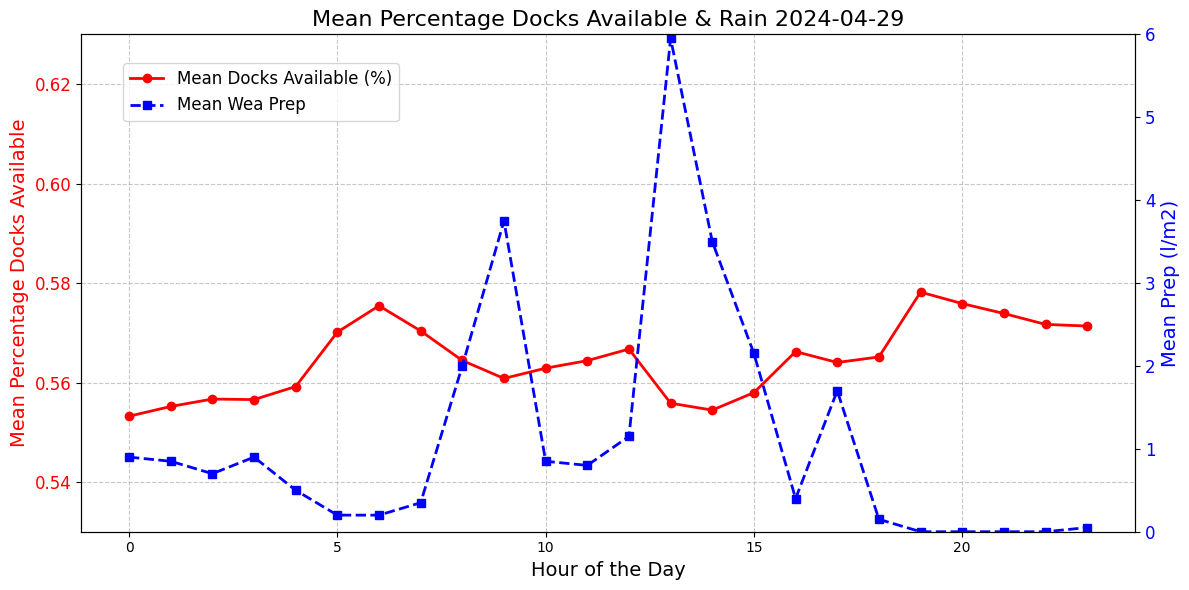

In [ ]:
import matplotlib.pyplot as plt

# Filter data where wea_prep > 3 and hour is between 9-15
df_filtered = df[(df["wea_prep"] >3) & (df["hour"].between(7, 11)) & (df["month"]==4) & (df["day_of_week"].between(0,4)) ]

# Ensure 'datetime' is the column where the date is stored, and extract the unique dates
unique_dates = df_filtered['datetime'].dt.date.unique()

# Randomly pick a date
random_date = random.choice(unique_dates)

# Filter the dataframe for the randomly picked date
df_date = df[df['datetime'].dt.date == random_date]

# Group by hour and compute the mean
df_mean = df_date.groupby("hour")[["percentage_docks_available", "wea_prep"]].mean()

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 6))  # Increase figure size for better clarity

# Plot mean percentage_docks_available
ax1.plot(df_mean.index, df_mean["percentage_docks_available"], marker="o", linestyle="-", color="r", label="Mean Docks Available (%)", linewidth=2)

# Set xlabel, ylabel with larger font size
ax1.set_xlabel("Hour of the Day", fontsize=14)
ax1.set_ylabel("Mean Percentage Docks Available", color="r", fontsize=14)
ax1.tick_params(axis="y", labelcolor="r", labelsize=12)

# Create a second y-axis for wea_prep
ax2 = ax1.twinx()
ax2.plot(df_mean.index, df_mean["wea_prep"], marker="s", linestyle="--", color="b", label="Mean Wea Prep", linewidth=2)

# Set second ylabel with larger font size
ax2.set_ylabel("Mean Prep (l/m2)", color="b", fontsize=14)
ax2.tick_params(axis="y", labelcolor="b", labelsize=12)

# Set y-axis limits for ax1
ax1.set_ylim(0.53, 0.63)

# Set y-axis limits for ax2 (Wea Prep)
ax2.set_ylim(0, 6)

# Title with larger font size
plt.title(f"Mean Percentage Docks Available & Rain {random_date}", fontsize=16)

# Increase gridlines for better visibility
ax1.grid(True, linestyle='--', alpha=0.7)

# Add a legend for clarity
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), fontsize=12)

# Adjust layout for better spacing
fig.tight_layout()

# Show plot
plt.show()


In [ ]:
df['FCB_Location'].unique()

['NoMatch', 'F', 'N', 'C']
Categories (4, object): ['C', 'F', 'N', 'NoMatch']

In [ ]:
import pandas as pd

# Step 1: Filter data for station_id 312 and year 2022
df_filtered = df[(df['station_id'] == 312) & (df['year'] == 2022)]

# Step 2: Filter data where FCB_Location == 'C'
df_location_C = df_filtered[df_filtered['FCB_Location'] == 'C']

# Step 3: Find the most common hour for FCB_Location == 'C'
most_common_hour_C = df_location_C['hour'].mode()[0]

# Step 4: Filter data for the most common hour for 'C'
df_common_hour_C = df_location_C[df_location_C['hour'] == most_common_hour_C]

# Step 5: Calculate the percentage of docks available for 'C'
percentage_docks_available_C = df_common_hour_C['percentage_docks_available'].mean()

# Step 6: Filter data where FCB_Location == 'No_Match'
df_location_No_Match = df_filtered[df_filtered['FCB_Location'] == 'NoMatch']

# Step 8: Filter data for the most common hour for 'No_Match'
df_common_hour_No_Match = df_location_No_Match[df_location_No_Match['hour'] == most_common_hour_C]

# Step 9: Calculate the percentage of docks available for 'No_Match'
percentage_docks_available_No_Match = df_common_hour_No_Match['percentage_docks_available'].mean()

# Output the comparison
print(f"Percentage of docks available for station 312 when FCB_Location == 'C' and hour == {most_common_hour_C}: {percentage_docks_available_C:.2f}%")
print(f"Percentage of docks available for station 312 when FCB_Location == 'NoMatch' and hour == {most_common_hour_C}: {percentage_docks_available_No_Match:.2f}%")


Percentage of docks available for station 312 when FCB_Location == 'C' and hour == 19: 0.10%
Percentage of docks available for station 312 when FCB_Location == 'NoMatch' and hour == 19: 0.73%
